In [1]:
seed = 0

import os
import sys

os.chdir('..')
utils_path = os.path.abspath("./utilities/")
sys.path.append(utils_path)

from load_data import load_fullECAI
from evaluation import *
from evaluation import _my_scorer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, Normalizer
from sklearn.metrics import precision_score

import joblib
from joblib import Parallel, delayed
import shap

from igraph import Graph
import igraph as ig

/home/azaelcarrillo/miniconda3/envs/XAI_credit/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### LOAD DATA ###
dataset = load_fullECAI()
# Prep data
X = dataset.drop('status', axis=1)
y = dataset.loc[:, 'status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=seed, stratify=y)

In [3]:
models_paths = ['./results/XGBoost/GridSearchCV_22-03-22_03-27-03/models/best/best_xgb.pkl', 
                './results/Basic/models/RandomForestClassifier.pkl',
                './results/Basic/models/XGBClassifier.pkl',
                './results/Basic/models/LogisticRegression.pkl',
                './results/Basic/models/LinearDiscriminantAnalysis.pkl']

In [4]:
def community_analysis(communities, model_name, y_pred):
    communities_info = []
    for i, community in enumerate(communities):
        y_test_community = np.array(y_test)[community]
        y_pred_community = y_pred[community]

        community_chars = {}
        community_chars['Modelo'] = model_name
        community_chars['Comunidad'] = i
        community_chars['Tamaño'] = len(community)
        community_chars['Tamaño %'] = len(community)/len(y_pred)
        community_chars['Modularidad'] = communities.modularity
        
        community_chars['Impago_pred'] = np.sum(y_pred_community)
        community_chars['pago_pred'] = np.sum((y_pred_community != 1)*1)
        
        community_chars['Impago_real'] = np.sum(y_test_community)
        community_chars['pago_real'] = np.sum((y_test_community != 1)*1)
        
        error = y_test_community != y_pred_community
        community_chars['Fallos'] = np.sum(error)
        community_chars['precision_1_en_comunidad'] = precision_score(y_test_community, y_pred_community, pos_label=1)
        community_chars['precision_0_en_comunidad'] = precision_score(y_test_community, y_pred_community, pos_label=0)

        community_chars['precision_1_total'] = precision_score(y_test, y_pred, pos_label=1)
        community_chars['precision_0_total'] = precision_score(y_test, y_pred, pos_label=0)

        communities_info.append(community_chars)
        
    return communities_info

## Análisis de comunidades por Louvain

In [5]:
optimal_cutoffs = [2, 1, 2, 0, 0]

graphs = []
y_preds = []
y_probas = []
for i, model in enumerate(models_paths):
    model_folder = '/'.join(model.split('/')[:-1])
    model_name = model.split('/')[-1].split('.')[0]
    results = joblib.load('{}/{}_reduced_graphs_efficiency.pkl'.format(model_folder, model_name))
    result_optimal = results[optimal_cutoffs[i]]
    graph = result_optimal[3]
    
    model_results = joblib.load(model)
    y_pred = model_results['y_pred']
    y_proba = model_results['y_proba'][:,1]
    
    graphs.append(graph)
    y_preds.append(y_pred)
    y_probas.append(y_proba)
results = None

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [6]:
communities_data = []
for i, model in enumerate(models_paths):
    model_folder = '/'.join(model.split('/')[:-1])
    model_name = model.split('/')[-1].split('.')[0]

    y_pred = y_preds[i]
    y_proba = y_probas[i]
    graph = graphs[i]
    graph = graph.clusters().giant()
    
    #communities = graph.community_infomap(edge_weights=1 - np.array(graph.es['weight'])/np.max(graph.es['weight']), vertex_weights=y_proba, trials=20)
    communities = graph.community_multilevel(weights=1 - np.array(graph.es['weight'])/np.max(graph.es['weight']))
    #communities = graph.community_fastgreedy(weights=1 - np.array(graph.es['weight'])/np.max(graph.es['weight']))
    #communities = communities.as_clustering(n=2)
    
    communities_info = community_analysis(communities, model_name, y_pred)
    communities_data = communities_data + communities_info
    
communities_df = pd.DataFrame(communities_data).set_index(['Modelo', 'Comunidad'])
communities_df.to_csv('./results/communities_louvain_str1.csv')

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

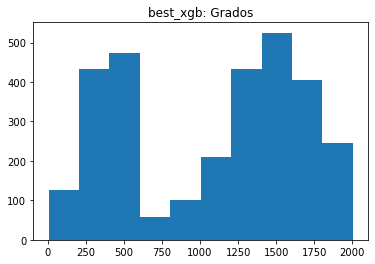

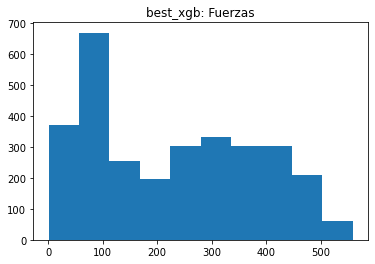

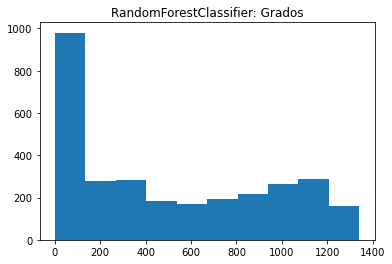

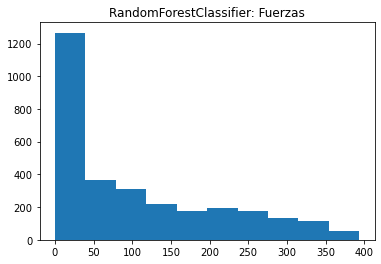

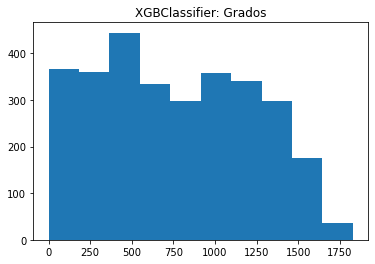

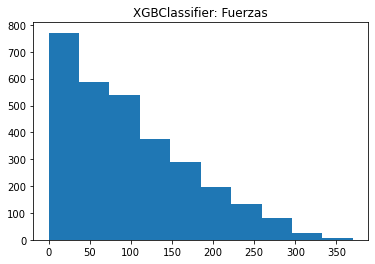

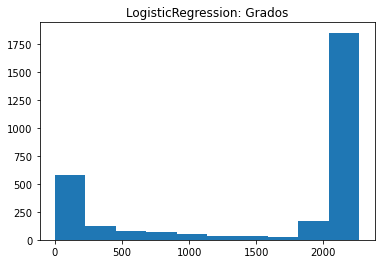

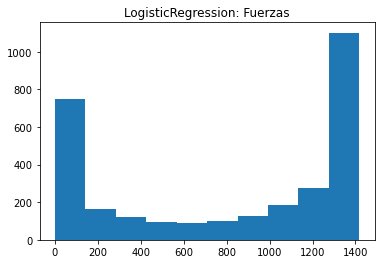

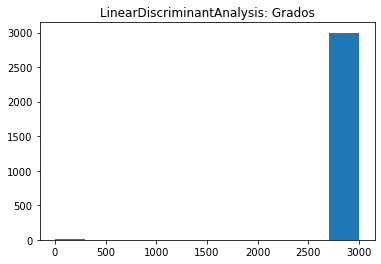

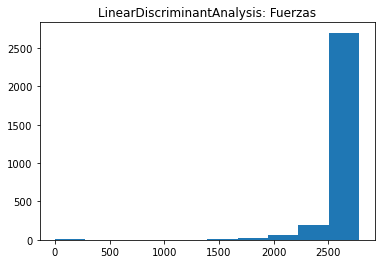

In [454]:
# Distribution
powerlaw_data = []
for i, model in enumerate(models_paths):
    model_folder = '/'.join(model.split('/')[:-1])
    model_name = model.split('/')[-1].split('.')[0]
    graph = graphs[i]
        
    values = [graph.degree(graph.vs),
              graph.strength(graph.vs, loops=False, weights=1 - np.array(graph.es['weight'])/np.max(graph.es['weight']))]
    
    typesv = ['Grados', 'Fuerzas']
    for value, typev in zip(values, typesv):
        plt.hist(value)
        plt.title('{}: {}'.format(model_name, typev))
        plt.savefig('results/figures/str_deg_distributions/{}-{}.png'.format(model_name,typev), 
                    bbox_inches='tight', 
                    dpi=300, 
                    transparent=True)
        plt.show()

In [498]:
sigs = []
for i, model in enumerate(models_paths):
    model_folder = '/'.join(model.split('/')[:-1])
    model_name = model.split('/')[-1].split('.')[0]

    y_pred = y_preds[i]
    y_proba = y_probas[i]
    graph = graphs[i]
    
    powerlaw_info = {}
    powerlaw_info['Modelo'] = model_name
    
    values = graph.degree(graph.vs)
    #values = graph.strength(graph.vs, loops=False, weights=1 - np.array(graph.es['weight'])/np.max(graph.es['weight']))
    
    #Via powerlaw
    #pl_fit = powerlaw.Fit(values, estimate_discrete=False, verbose=False)
    pl_fit = powerlaw.Fit(values, verbose=False)
    
    fittings = {}
    fittings['Modelo'] = model_name 
    
    R, p = pl_fit.distribution_compare('power_law', 'exponential')
    fittings['Ha: Power_law, H0: exponential'] = p
    
    R, p = pl_fit.distribution_compare('power_law', 'lognormal')
    fittings['Ha: Power_law, H0: lognormal'] = p
    
    R, p = pl_fit.distribution_compare('power_law', 'truncated_power_law')
    fittings['Ha: Power_law, H0: truncated_power_law'] = p
    
    R, p = pl_fit.distribution_compare('power_law', 'stretched_exponential')
    fittings['Ha: Power_law, H0: stretched_exponential'] = p
    
    R, p = pl_fit.distribution_compare('power_law', 'lognormal_positive')
    fittings['Ha: Power_law, H0: lognormal_positive'] = p
    
    sigs.append(fittings)

sigs_df = pd.DataFrame(sigs).set_index('Modelo')
sigs_df.to_csv('./results/fitted_dist_deg.csv')

overflow encountered in double_scalars
invalid value encountered in multiply
Assuming nested distributions
overflow encountered in double_scalars
overflow encountered in double_scalars
Assuming nested distributions


Assuming nested distributions


Assuming nested distributions


invalid value encountered in true_divide
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
invalid value encountered in double_scalars
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


In [440]:
from scipy.special import kolmogorov
import powerlaw

powerlaw_data = []
for i, model in enumerate(models_paths):
    model_folder = '/'.join(model.split('/')[:-1])
    model_name = model.split('/')[-1].split('.')[0]

    y_pred = y_preds[i]
    y_proba = y_probas[i]
    graph = graphs[i]
    
    powerlaw_info = {}
    powerlaw_info['Modelo'] = model_name
    
    values = graph.degree(graph.vs)
    #values = 1 - np.array(graph.es['weight'])/np.max(graph.es['weight'])
    #Via powerlaw
    #results = powerlaw.Fit(values, estimate_discrete=False)
    results = powerlaw.Fit(values)
    powerlaw_info['deg_alpha_powerlaw'] = results.power_law.alpha
    powerlaw_info['deg_xmin_powerlaw'] = results.power_law.xmin
    powerlaw_info['deg_p_powerlaw'] = kolmogorov(np.sqrt(3009)*results.D)
    
    # Via igraph
    fitted = ig.statistics.power_law_fit(values)
    powerlaw_info['deg_alpha_igraph'] = fitted.alpha
    powerlaw_info['deg_xmin_igraph'] = fitted.xmin
    powerlaw_info['deg_p_igraph'] = fitted.p
    
    powerlaw_data.append(powerlaw_info)

powerlaw_df = pd.DataFrame(powerlaw_data).set_index(['Modelo'])
#powerlaw_df.to_csv('./results/powerlaw_str.csv')

In [47]:
largest_component = graph.clusters().giant()
comms = largest_component.community_fastgreedy(weights=1 - np.array(largest_component.es['weight']))
comms.as_clustering(n=2)

KeyboardInterrupt: 

In [22]:
# Acceder a las comunidades

for i, community in enumerate(communities):
    print(f"Community {i}:")
    for v in community:
        print(f"\t{graph.vs[v].index}")

Community 0:
	0
	1
	22
	57
	67
	74
	78
	131
	141
	147
	155
	180
	183
	186
	193
	198
	231
	243
	249
	262
	282
	291
	308
	369
	380
	391
	394
	402
	413
	438
	443
	452
	563
	571
	573
	593
	604
	610
	611
	640
	652
	682
	692
	721
	735
	746
	747
	751
	760
	764
	766
	771
	813
	830
	833
	842
	852
	896
	907
	911
	920
	934
	993
	999
	1006
	1026
	1033
	1073
	1089
	1101
	1136
	1148
	1159
	1174
	1190
	1200
	1219
	1230
	1246
	1261
	1264
	1277
	1313
	1319
	1326
	1363
	1381
	1385
	1403
	1432
	1439
	1461
	1463
	1464
	1504
	1511
	1559
	1560
	1563
	1572
	1580
	1615
	1622
	1632
	1765
	1792
	1802
	1807
	1814
	1816
	1819
	1820
	1867
	1905
	1907
	1920
	1926
	1934
	1939
	2007
	2013
	2027
	2037
	2049
	2087
	2114
	2122
	2135
	2141
	2143
	2147
	2157
	2195
	2207
	2210
	2229
	2237
	2240
	2265
	2273
	2275
	2322
	2324
	2351
	2387
	2390
	2404
	2437
	2455
	2479
	2481
	2485
	2487
	2488
	2491
	2510
	2518
	2573
	2574
	2575
	2582
	2588
	2613
	2626
	2631
	2647
	2666
	2671
	2710
	2714
	2743
	2778
	2786
	2788
	2805
	2810
	285

## Plotear comunidades (NO TERMINADO)

In [24]:
# Set community colors
num_communities = len(communities)
palette1 = ig.RainbowPalette(n=num_communities)
for i, community in enumerate(communities):
    g.vs[community]["color"] = i
    community_edges = g.es.select(_within=community)
    community_edges["color"] = i

#g.vs["label"] = ["\n\n" + label for label in g.vs["label"]] # Move the labels below the vertices

In [45]:
fig, ax = plt.subplots()
a = ax.plot([1,2,3],)
plt.close()
fig.savefig("communities.png", dpi=200)

In [ ]:
ig.plot()

In [47]:
fig1, ax1 = plt.subplots()
ig.plot(
    communities,
    target=ax1,
    mark_groups=True,
    palette=palette1,
    vertex_size=0.1,
    edge_width=0.5,
    inline=False
)
fig1.set_size_inches(20, 20)

plt.close()
fig1.savefig("communities.png", dpi=200)